## Imports

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

PATH = "/content/drive/MyDrive/Medical Image/CT scan segmentation"

images = np.load(PATH + '/images_medseg.npy').astype(np.float32)
masks = np.load(PATH + '/masks_medseg.npy').astype(np.float32)

In [4]:
print("Images Shape:", images.shape)
print("Masks Shape:", masks.shape)

Images Shape: (100, 512, 512, 1)
Masks Shape: (100, 512, 512, 4)


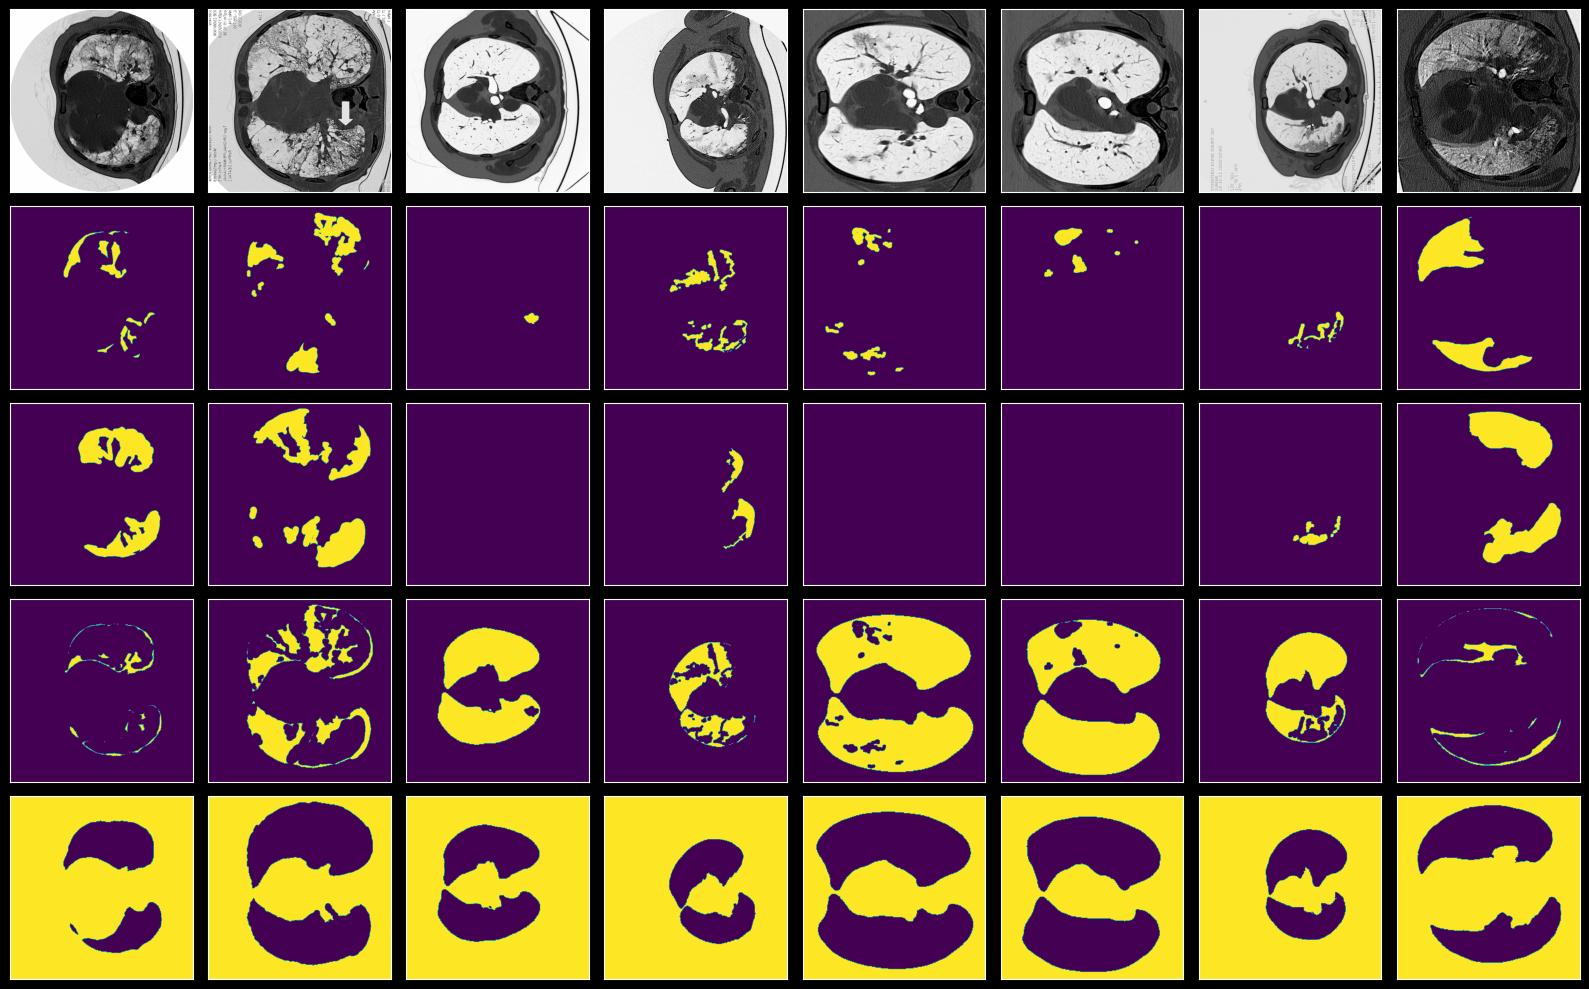

In [5]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    #print(j)
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()


visualize(images, masks)

# Dataset

In [6]:
import torch
from torchvision import transforms

class Dataset(torch.utils.data.Dataset):

  def __init__(self, data_dir, transform=None, images=None, masks=None):
    self.data_dir = data_dir
    self.images = images
    self.masks = masks
    self.transform = transform
    self.mask_transform = transform = transforms.Compose([transforms.ToTensor(),
                                                          transforms.Resize((256, 256), antialias=True)])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    mask = self.masks[idx]
    mask = mask.astype(np.float32)
    image = image.astype(np.float32)
    if self.transform:
      image = self.transform(image)
      mask = self.mask_transform(mask)
    return image, mask

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), antialias=True),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = Dataset(None, images=images, masks=masks, transform=transform)

In [7]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_size = int(0.5 * len(val_dataset))
val_size = len(val_dataset) - test_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle = True)

# U-net model

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, channels_in, num_classes):
        super(UNet, self).__init__()

        self.down_conv1 = DownConv(channels_in, 32)
        self.down_conv2 = DownConv(32, 64)
        self.down_conv3 = DownConv(64, 128)
        self.down_conv4 = DownConv(128, 256)

        self.middle_layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)   
        )

        self.up_conv1 = UpConv(512, 256)
        self.up_conv2 = UpConv(256, 128)
        self.up_conv3 = UpConv(128, 64)
        self.up_conv4 = UpConv(64, 32, convT = False)

        self.last_layer = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1),
            nn.Sigmoid()
        )


    def __call__(self, x):
        x, dc1 = self.down_conv1(x)
        x, dc2 = self.down_conv2(x)
        x, dc3 = self.down_conv3(x)
        x, dc4 = self.down_conv4(x)
        x = self.middle_layer(x)
        x = self.up_conv1(x, dc4)
        x = self.up_conv2(x, dc3)
        x = self.up_conv3(x, dc2)
        x = self.up_conv4(x, dc1)
        x = self.last_layer(x)
        return x
        
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, convT = True):
        super(UpConv, self).__init__()
        
        self.convT = convT
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.trans_conv = nn.ConvTranspose2d(out_channels, out_channels // 2, kernel_size=2, stride=2)

    def __call__(self, x, dc):
        
        x = torch.cat([x, dc], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        if self.convT:
            x = self.trans_conv(x)
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def __call__(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        dc = x
        x = self.max_pool(x)
        return x, dc

In [9]:
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(1, 1).to(device)
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
            Conv2d-3         [-1, 32, 256, 256]           9,248
       BatchNorm2d-4         [-1, 32, 256, 256]              64
         MaxPool2d-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]          18,496
       BatchNorm2d-7         [-1, 64, 128, 128]             128
            Conv2d-8         [-1, 64, 128, 128]          36,928
       BatchNorm2d-9         [-1, 64, 128, 128]             128
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]          73,856
      BatchNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 128, 64, 64]         147,584
      BatchNorm2d-14          [-1, 128,

## IOU

$$
IOU(A,B) = \frac{|A\cap B|}{|A \cup B|}
$$

In [10]:
from torchmetrics.classification import BinaryJaccardIndex

def IoU(output, target):
  target = target > 0.5
  metric = BinaryJaccardIndex().to(device)
  return metric(output, target).detach().cpu()

In [11]:
import torch.optim as optim

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = nn.BCELoss()

In [12]:
from tqdm import tqdm

CLASS = 0
def train(model, train_dataloader, validation_dataloader, num_epochs, criterion):

    model.cuda()
    train_loss, valid_loss = [], []
    train_IoU, valid_IoU = [], []
    best_IoU = 0.0
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        running_loss = 0.0
        running_IoU = 0.0
        model.train()

        for image, mask in tqdm(train_dataloader):
            mask = mask[:, CLASS, :, :]
            mask.unsqueeze_(1)
            image, mask = image.to(device), mask.to(device)
            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()
            running_loss += loss * train_dataloader.batch_size
            running_IoU += IoU(outputs > 0.5, mask)
 
        epoch_loss = running_loss / len(train_dataloader)
        train_loss.append(epoch_loss)
        epoch_IoU = running_IoU / len(train_dataloader)
        train_IoU.append(epoch_IoU)
        print('Epoch: ', epoch, 'Train-Loss: ', epoch_loss.item())
        print('Epoch: ', epoch, 'Train-IoU: ', epoch_IoU)
        model.eval()
        total_IOU = 0
        running_loss = 0
        running_IoU = 0.0
        with torch.no_grad():
            for image, mask in tqdm(validation_dataloader):
                mask = mask[:,CLASS,:,:]
                mask.unsqueeze_(1)
                image, mask = image.to(device), mask.to(device)
                outputs = model(image)
                running_IoU += IoU(outputs> 0.5, mask)
                running_loss += criterion(outputs, mask) * validation_dataloader.batch_size
                
            val_loss = running_loss / len(validation_dataloader)
            valid_loss.append(val_loss)
            val_IoU = running_IoU / len(validation_dataloader)
            valid_IoU.append(val_IoU)
            print('Epoch: ', epoch, 'Val-Loss: ', val_loss.item())
            print('Epoch: ', epoch, 'Val-IoU: ', val_IoU)
            if val_IoU > best_IoU :
                val_IoU = best_IoU
                torch.save(model.state_dict(), 'best_model.pth')
        scheduler.step(val_loss)

    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_loss, valid_loss, train_IoU, valid_IoU



def test(model, test_dataloader):
    model.eval()
    ious = []
    for image, mask in test_dataloader:
        mask = mask[:,CLASS,:,:]
        image = image.to(device)
        mask = mask.to(device)
        mask.unsqueeze_(1)
        outputs = model(image)
        pred_mask = (outputs > 0.5)
        iou = IoU(pred_mask, mask)
        ious.append(iou)
    print('Mean IoU: ', np.mean(ious))
                 

In [13]:
model, train_loss, valid_loss, train_IoU, valid_IoU = train(model, train_loader, val_loader, 50, criterion)

Epoch 1/50


100%|██████████| 20/20 [00:02<00:00,  6.73it/s]


Epoch:  0 Train-Loss:  2.945054292678833
Epoch:  0 Train-IoU:  tensor(0.0693)


100%|██████████| 3/3 [00:00<00:00, 20.18it/s]


Epoch:  0 Val-Loss:  2.2871572971343994
Epoch:  0 Val-IoU:  tensor(0.0010)
Epoch 2/50


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Epoch:  1 Train-Loss:  2.208449602127075
Epoch:  1 Train-IoU:  tensor(0.1817)


100%|██████████| 3/3 [00:00<00:00, 14.98it/s]


Epoch:  1 Val-Loss:  1.8163213729858398
Epoch:  1 Val-IoU:  tensor(0.3343)
Epoch 3/50


100%|██████████| 20/20 [00:02<00:00,  7.00it/s]


Epoch:  2 Train-Loss:  1.6577188968658447
Epoch:  2 Train-IoU:  tensor(0.3214)


100%|██████████| 3/3 [00:00<00:00, 15.51it/s]


Epoch:  2 Val-Loss:  1.4748648405075073
Epoch:  2 Val-IoU:  tensor(0.3717)
Epoch 4/50


100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


Epoch:  3 Train-Loss:  1.3337984085083008
Epoch:  3 Train-IoU:  tensor(0.3335)


100%|██████████| 3/3 [00:00<00:00, 18.16it/s]


Epoch:  3 Val-Loss:  1.2085273265838623
Epoch:  3 Val-IoU:  tensor(0.4152)
Epoch 5/50


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Epoch:  4 Train-Loss:  1.1134026050567627
Epoch:  4 Train-IoU:  tensor(0.2745)


100%|██████████| 3/3 [00:00<00:00, 19.58it/s]


Epoch:  4 Val-Loss:  0.982756495475769
Epoch:  4 Val-IoU:  tensor(0.2715)
Epoch 6/50


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


Epoch:  5 Train-Loss:  0.9489126205444336
Epoch:  5 Train-IoU:  tensor(0.2736)


100%|██████████| 3/3 [00:00<00:00, 19.42it/s]


Epoch:  5 Val-Loss:  0.8824018239974976
Epoch:  5 Val-IoU:  tensor(0.3485)
Epoch 7/50


100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


Epoch:  6 Train-Loss:  0.8585314750671387
Epoch:  6 Train-IoU:  tensor(0.2721)


100%|██████████| 3/3 [00:00<00:00, 15.73it/s]


Epoch:  6 Val-Loss:  0.76609867811203
Epoch:  6 Val-IoU:  tensor(0.3525)
Epoch 8/50


100%|██████████| 20/20 [00:02<00:00,  6.80it/s]


Epoch:  7 Train-Loss:  0.7746947407722473
Epoch:  7 Train-IoU:  tensor(0.2451)


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


Epoch:  7 Val-Loss:  0.707044780254364
Epoch:  7 Val-IoU:  tensor(0.1909)
Epoch 9/50


100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


Epoch:  8 Train-Loss:  0.7187120318412781
Epoch:  8 Train-IoU:  tensor(0.2054)


100%|██████████| 3/3 [00:00<00:00, 18.54it/s]


Epoch:  8 Val-Loss:  0.6373185515403748
Epoch:  8 Val-IoU:  tensor(0.2579)
Epoch 10/50


100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


Epoch:  9 Train-Loss:  0.6609132885932922
Epoch:  9 Train-IoU:  tensor(0.2713)


100%|██████████| 3/3 [00:00<00:00, 18.75it/s]


Epoch:  9 Val-Loss:  0.5997387766838074
Epoch:  9 Val-IoU:  tensor(0.3754)
Epoch 11/50


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Epoch:  10 Train-Loss:  0.6487118601799011
Epoch:  10 Train-IoU:  tensor(0.2880)


100%|██████████| 3/3 [00:00<00:00, 19.34it/s]


Epoch:  10 Val-Loss:  0.5512682795524597
Epoch:  10 Val-IoU:  tensor(0.3059)
Epoch 12/50


100%|██████████| 20/20 [00:02<00:00,  7.27it/s]


Epoch:  11 Train-Loss:  0.5975878238677979
Epoch:  11 Train-IoU:  tensor(0.2850)


100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


Epoch:  11 Val-Loss:  0.5655232667922974
Epoch:  11 Val-IoU:  tensor(0.3652)
Epoch 13/50


100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


Epoch:  12 Train-Loss:  0.5670698285102844
Epoch:  12 Train-IoU:  tensor(0.3101)


100%|██████████| 3/3 [00:00<00:00, 19.14it/s]


Epoch:  12 Val-Loss:  0.5059109330177307
Epoch:  12 Val-IoU:  tensor(0.3512)
Epoch 14/50


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Epoch:  13 Train-Loss:  0.5803484916687012
Epoch:  13 Train-IoU:  tensor(0.2799)


100%|██████████| 3/3 [00:00<00:00, 19.23it/s]


Epoch:  13 Val-Loss:  0.5035349130630493
Epoch:  13 Val-IoU:  tensor(0.3996)
Epoch 15/50


100%|██████████| 20/20 [00:02<00:00,  7.72it/s]


Epoch:  14 Train-Loss:  0.5308111906051636
Epoch:  14 Train-IoU:  tensor(0.3217)


100%|██████████| 3/3 [00:00<00:00, 19.50it/s]


Epoch:  14 Val-Loss:  0.5100439786911011
Epoch:  14 Val-IoU:  tensor(0.3596)
Epoch 16/50


100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


Epoch:  15 Train-Loss:  0.5196191072463989
Epoch:  15 Train-IoU:  tensor(0.3173)


100%|██████████| 3/3 [00:00<00:00, 19.38it/s]


Epoch:  15 Val-Loss:  0.48810887336730957
Epoch:  15 Val-IoU:  tensor(0.3681)
Epoch 17/50


100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


Epoch:  16 Train-Loss:  0.5122619271278381
Epoch:  16 Train-IoU:  tensor(0.3368)


100%|██████████| 3/3 [00:00<00:00, 15.31it/s]


Epoch:  16 Val-Loss:  0.45250028371810913
Epoch:  16 Val-IoU:  tensor(0.4314)
Epoch 18/50


100%|██████████| 20/20 [00:02<00:00,  7.34it/s]


Epoch:  17 Train-Loss:  0.5050133466720581
Epoch:  17 Train-IoU:  tensor(0.3242)


100%|██████████| 3/3 [00:00<00:00, 19.07it/s]


Epoch:  17 Val-Loss:  0.42332035303115845
Epoch:  17 Val-IoU:  tensor(0.3969)
Epoch 19/50


100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


Epoch:  18 Train-Loss:  0.4893680512905121
Epoch:  18 Train-IoU:  tensor(0.3417)


100%|██████████| 3/3 [00:00<00:00, 18.49it/s]


Epoch:  18 Val-Loss:  0.4675082862377167
Epoch:  18 Val-IoU:  tensor(0.3853)
Epoch 20/50


100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


Epoch:  19 Train-Loss:  0.48979589343070984
Epoch:  19 Train-IoU:  tensor(0.3002)


100%|██████████| 3/3 [00:00<00:00, 19.65it/s]


Epoch:  19 Val-Loss:  0.412000834941864
Epoch:  19 Val-IoU:  tensor(0.4201)
Epoch 21/50


100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


Epoch:  20 Train-Loss:  0.459665983915329
Epoch:  20 Train-IoU:  tensor(0.3456)


100%|██████████| 3/3 [00:00<00:00, 15.29it/s]


Epoch:  20 Val-Loss:  0.3921116292476654
Epoch:  20 Val-IoU:  tensor(0.3859)
Epoch 22/50


100%|██████████| 20/20 [00:02<00:00,  6.68it/s]


Epoch:  21 Train-Loss:  0.4613130986690521
Epoch:  21 Train-IoU:  tensor(0.3579)


100%|██████████| 3/3 [00:00<00:00, 14.52it/s]


Epoch:  21 Val-Loss:  0.39463138580322266
Epoch:  21 Val-IoU:  tensor(0.4130)
Epoch 23/50


100%|██████████| 20/20 [00:02<00:00,  7.49it/s]


Epoch:  22 Train-Loss:  0.4643101692199707
Epoch:  22 Train-IoU:  tensor(0.3513)


100%|██████████| 3/3 [00:00<00:00, 16.45it/s]


Epoch:  22 Val-Loss:  0.3843582272529602
Epoch:  22 Val-IoU:  tensor(0.3820)
Epoch 24/50


100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


Epoch:  23 Train-Loss:  0.4636825621128082
Epoch:  23 Train-IoU:  tensor(0.3380)


100%|██████████| 3/3 [00:00<00:00, 19.12it/s]


Epoch:  23 Val-Loss:  0.3991304636001587
Epoch:  23 Val-IoU:  tensor(0.4200)
Epoch 25/50


100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


Epoch:  24 Train-Loss:  0.4358227252960205
Epoch:  24 Train-IoU:  tensor(0.4132)


100%|██████████| 3/3 [00:00<00:00,  9.33it/s]


Epoch:  24 Val-Loss:  0.3746980130672455
Epoch:  24 Val-IoU:  tensor(0.4462)
Epoch 26/50


100%|██████████| 20/20 [00:03<00:00,  6.25it/s]


Epoch:  25 Train-Loss:  0.42180928587913513
Epoch:  25 Train-IoU:  tensor(0.3695)


100%|██████████| 3/3 [00:00<00:00, 15.05it/s]


Epoch:  25 Val-Loss:  0.3729167878627777
Epoch:  25 Val-IoU:  tensor(0.4603)
Epoch 27/50


100%|██████████| 20/20 [00:02<00:00,  7.22it/s]


Epoch:  26 Train-Loss:  0.46576109528541565
Epoch:  26 Train-IoU:  tensor(0.3497)


100%|██████████| 3/3 [00:00<00:00, 19.51it/s]


Epoch:  26 Val-Loss:  0.41892609000205994
Epoch:  26 Val-IoU:  tensor(0.4662)
Epoch 28/50


100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


Epoch:  27 Train-Loss:  0.4115462303161621
Epoch:  27 Train-IoU:  tensor(0.3903)


100%|██████████| 3/3 [00:00<00:00, 18.69it/s]


Epoch:  27 Val-Loss:  0.34963202476501465
Epoch:  27 Val-IoU:  tensor(0.4366)
Epoch 29/50


100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


Epoch:  28 Train-Loss:  0.41086092591285706
Epoch:  28 Train-IoU:  tensor(0.3861)


100%|██████████| 3/3 [00:00<00:00, 17.81it/s]


Epoch:  28 Val-Loss:  0.3655790686607361
Epoch:  28 Val-IoU:  tensor(0.4785)
Epoch 30/50


100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


Epoch:  29 Train-Loss:  0.4009566307067871
Epoch:  29 Train-IoU:  tensor(0.3956)


100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


Epoch:  29 Val-Loss:  0.3461558222770691
Epoch:  29 Val-IoU:  tensor(0.4302)
Epoch 31/50


100%|██████████| 20/20 [00:02<00:00,  6.84it/s]


Epoch:  30 Train-Loss:  0.42211270332336426
Epoch:  30 Train-IoU:  tensor(0.3867)


100%|██████████| 3/3 [00:00<00:00, 15.10it/s]


Epoch:  30 Val-Loss:  0.3725960850715637
Epoch:  30 Val-IoU:  tensor(0.5046)
Epoch 32/50


100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


Epoch:  31 Train-Loss:  0.4045965373516083
Epoch:  31 Train-IoU:  tensor(0.3915)


100%|██████████| 3/3 [00:00<00:00, 17.80it/s]


Epoch:  31 Val-Loss:  0.3416987657546997
Epoch:  31 Val-IoU:  tensor(0.4568)
Epoch 33/50


100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


Epoch:  32 Train-Loss:  0.4034031927585602
Epoch:  32 Train-IoU:  tensor(0.4000)


100%|██████████| 3/3 [00:00<00:00, 18.92it/s]


Epoch:  32 Val-Loss:  0.36960452795028687
Epoch:  32 Val-IoU:  tensor(0.4754)
Epoch 34/50


100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


Epoch:  33 Train-Loss:  0.41937580704689026
Epoch:  33 Train-IoU:  tensor(0.3647)


100%|██████████| 3/3 [00:00<00:00, 19.01it/s]


Epoch:  33 Val-Loss:  0.393093466758728
Epoch:  33 Val-IoU:  tensor(0.4229)
Epoch 35/50


100%|██████████| 20/20 [00:02<00:00,  7.19it/s]


Epoch:  34 Train-Loss:  0.42426809668540955
Epoch:  34 Train-IoU:  tensor(0.3606)


100%|██████████| 3/3 [00:00<00:00, 14.82it/s]


Epoch:  34 Val-Loss:  0.40878304839134216
Epoch:  34 Val-IoU:  tensor(0.3741)
Epoch 36/50


100%|██████████| 20/20 [00:02<00:00,  7.03it/s]


Epoch:  35 Train-Loss:  0.3995574414730072
Epoch:  35 Train-IoU:  tensor(0.3894)


100%|██████████| 3/3 [00:00<00:00, 19.25it/s]


Epoch:  35 Val-Loss:  0.36735162138938904
Epoch:  35 Val-IoU:  tensor(0.4172)
Epoch 37/50


100%|██████████| 20/20 [00:02<00:00,  7.72it/s]


Epoch:  36 Train-Loss:  0.385412335395813
Epoch:  36 Train-IoU:  tensor(0.3985)


100%|██████████| 3/3 [00:00<00:00, 19.96it/s]


Epoch:  36 Val-Loss:  0.3151359558105469
Epoch:  36 Val-IoU:  tensor(0.4704)
Epoch 38/50


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Epoch:  37 Train-Loss:  0.38870760798454285
Epoch:  37 Train-IoU:  tensor(0.4304)


100%|██████████| 3/3 [00:00<00:00, 19.15it/s]


Epoch:  37 Val-Loss:  0.3476942181587219
Epoch:  37 Val-IoU:  tensor(0.4761)
Epoch 39/50


100%|██████████| 20/20 [00:02<00:00,  7.72it/s]


Epoch:  38 Train-Loss:  0.3915031850337982
Epoch:  38 Train-IoU:  tensor(0.4006)


100%|██████████| 3/3 [00:00<00:00, 19.95it/s]


Epoch:  38 Val-Loss:  0.3683902621269226
Epoch:  38 Val-IoU:  tensor(0.5125)
Epoch 40/50


100%|██████████| 20/20 [00:02<00:00,  6.97it/s]


Epoch:  39 Train-Loss:  0.39073535799980164
Epoch:  39 Train-IoU:  tensor(0.3916)


100%|██████████| 3/3 [00:00<00:00, 15.92it/s]


Epoch:  39 Val-Loss:  0.34620940685272217
Epoch:  39 Val-IoU:  tensor(0.4505)
Epoch 41/50


100%|██████████| 20/20 [00:02<00:00,  7.26it/s]


Epoch:  40 Train-Loss:  0.37127742171287537
Epoch:  40 Train-IoU:  tensor(0.4246)


100%|██████████| 3/3 [00:00<00:00, 18.98it/s]


Epoch:  40 Val-Loss:  0.3607935607433319
Epoch:  40 Val-IoU:  tensor(0.4633)
Epoch 42/50


100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


Epoch:  41 Train-Loss:  0.35337039828300476
Epoch:  41 Train-IoU:  tensor(0.4485)


100%|██████████| 3/3 [00:00<00:00, 19.02it/s]


Epoch:  41 Val-Loss:  0.32230064272880554
Epoch:  41 Val-IoU:  tensor(0.4775)
Epoch 43/50


100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


Epoch:  42 Train-Loss:  0.36036989092826843
Epoch:  42 Train-IoU:  tensor(0.4292)


100%|██████████| 3/3 [00:00<00:00, 20.25it/s]


Epoch:  42 Val-Loss:  0.3166198432445526
Epoch:  42 Val-IoU:  tensor(0.4449)
Epoch 44/50


100%|██████████| 20/20 [00:02<00:00,  7.46it/s]


Epoch:  43 Train-Loss:  0.38728153705596924
Epoch:  43 Train-IoU:  tensor(0.4046)


100%|██████████| 3/3 [00:00<00:00, 15.28it/s]


Epoch:  43 Val-Loss:  0.3119257390499115
Epoch:  43 Val-IoU:  tensor(0.4113)
Epoch 45/50


100%|██████████| 20/20 [00:03<00:00,  6.60it/s]


Epoch:  44 Train-Loss:  0.36596301198005676
Epoch:  44 Train-IoU:  tensor(0.4335)


100%|██████████| 3/3 [00:00<00:00, 14.83it/s]


Epoch:  44 Val-Loss:  0.35272058844566345
Epoch:  44 Val-IoU:  tensor(0.4688)
Epoch 46/50


100%|██████████| 20/20 [00:02<00:00,  7.48it/s]


Epoch:  45 Train-Loss:  0.35552459955215454
Epoch:  45 Train-IoU:  tensor(0.4298)


100%|██████████| 3/3 [00:00<00:00, 19.28it/s]


Epoch:  45 Val-Loss:  0.3387601375579834
Epoch:  45 Val-IoU:  tensor(0.4261)
Epoch 47/50


100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


Epoch:  46 Train-Loss:  0.3516627848148346
Epoch:  46 Train-IoU:  tensor(0.4570)


100%|██████████| 3/3 [00:00<00:00, 19.29it/s]


Epoch:  46 Val-Loss:  0.3524949252605438
Epoch:  46 Val-IoU:  tensor(0.4464)
Epoch 48/50


100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


Epoch:  47 Train-Loss:  0.36459818482398987
Epoch:  47 Train-IoU:  tensor(0.4182)


100%|██████████| 3/3 [00:00<00:00, 19.19it/s]


Epoch:  47 Val-Loss:  0.31989380717277527
Epoch:  47 Val-IoU:  tensor(0.4476)
Epoch 49/50


100%|██████████| 20/20 [00:02<00:00,  7.04it/s]


Epoch:  48 Train-Loss:  0.36788779497146606
Epoch:  48 Train-IoU:  tensor(0.4416)


100%|██████████| 3/3 [00:00<00:00, 15.01it/s]


Epoch:  48 Val-Loss:  0.42867645621299744
Epoch:  48 Val-IoU:  tensor(0.4842)
Epoch 50/50


100%|██████████| 20/20 [00:02<00:00,  6.87it/s]


Epoch:  49 Train-Loss:  0.3452058732509613
Epoch:  49 Train-IoU:  tensor(0.4430)


100%|██████████| 3/3 [00:00<00:00, 19.32it/s]


Epoch:  49 Val-Loss:  0.32190150022506714
Epoch:  49 Val-IoU:  tensor(0.4079)


In [14]:
test(model, test_loader)

Mean IoU:  0.39383185


<function matplotlib.pyplot.show(close=None, block=None)>

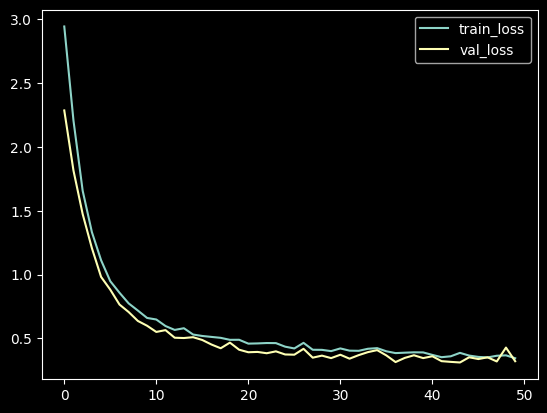

In [15]:
import matplotlib.pyplot as plt
tl = []
vl = []
for x in train_loss:
    tl.append(x.cpu().data)
for x in valid_loss:
    vl.append(x.cpu().data)
plt.plot(tl, label='train_loss')
plt.plot(vl, label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

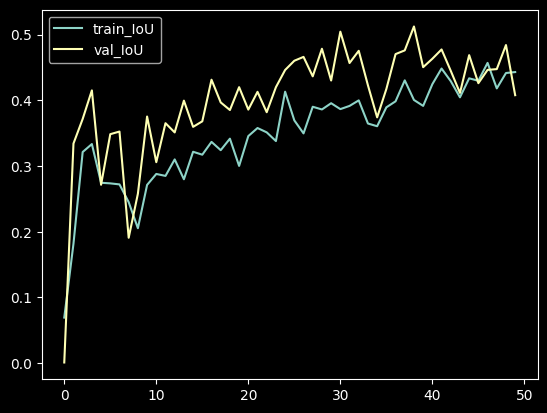

In [16]:
plt.plot(train_IoU, label='train_IoU')
plt.plot(valid_IoU, label='val_IoU')
plt.legend()
plt.show

## Visualize the models output on 4 of target images

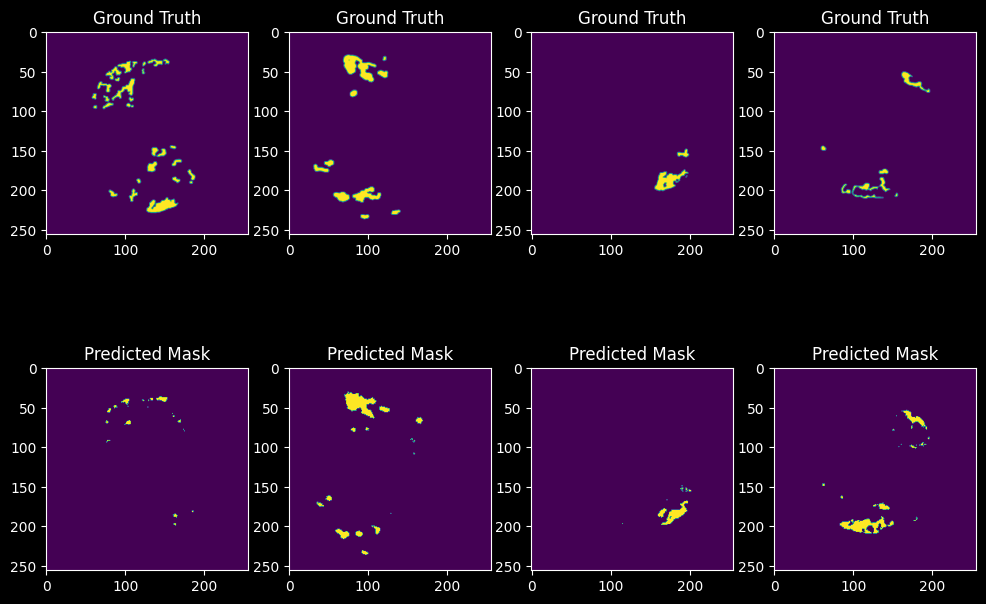

In [18]:
i = 0
fig, axis = plt.subplots(2, 4, figsize=(12,8))
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)
for image, mask in test_loader:
    if i==4:
        break
    axis[0,i].imshow(mask[-1][CLASS])
    axis[0,i].set_title('Ground Truth')
    image = image.to(device)
    mask = mask.to(device)
    pred_mask = model(image)
    pred_mask = pred_mask.detach().cpu().numpy()
    pred_mask = (pred_mask > 0.5)
    axis[1,i].imshow(pred_mask[-1][0])
    axis[1,i].set_title('Predicted Mask')
    i+=1

plt.show()